In [1]:
import sys
sys.path.append("../..")

import numpy as np
from emlopt import solvers, surrogates
from emlopt.utils import set_seed,  is_plot_visible, min_max_scale_in, min_max_restore_out, timer
from emlopt.problem import build_problem
from experiments.problems.simple_functions import polynomial, build_rosenbrock, mccormick

import logging
def create_logger(name):
    test_logger = logging.getLogger(name)
    stream = logging.StreamHandler(sys.stdout)
    stream.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
    if not test_logger.handlers:
        test_logger.addHandler(stream)
    test_logger.setLevel(logging.DEBUG)
    test_logger.propagate = False
    return test_logger
logger = create_logger('ebm')


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from emlopt.surrogates.base_surrogate import BaseSurrogate
from emlopt.utils import min_max_scale_in, min_max_scale_out
import matplotlib.pyplot as plt
import tempfile
import math

def build_regressor(input_shape, depth=4, width=20):
    mdl = tf.keras.Sequential()
    mdl.add(tf.keras.layers.Input(shape=(input_shape + 1,), dtype='float32'))
    for i in range(depth):
        mdl.add(tf.keras.layers.Dense(width, activation='relu'))
    mdl.add(tf.keras.layers.Dense(1, activation='linear'))
    return mdl

def gauss_density_centered(x, std):
    return tf.math.exp(-0.5*(x / std)**2) / (math.sqrt(2*math.pi)*std)

def gmm_density_centered(x, std):
    """
    Assumes dim=-1 is the component dimension and dim=-2 is feature dimension. Rest are sample dimension.
    """
    if len(x.shape) == len(std.shape) - 1:
        x = tf.expand_dims(x, axis=-1)
    elif not (x.shape == std.shape and x.shape[-1] == 1):
        raise ValueError('Last dimension must be the gmm stds.')
    return tf.math.reduce_mean(tf.math.reduce_prod(gauss_density_centered(x, std), axis=-2), axis=-1)

def sample_gmm_centered(std, num_samples=1):
    num_components = std.shape[-1]
    num_dims = tf.size(std) // num_components

    std = tf.reshape(std, (1, num_dims, num_components))

    # Sample component ids
    k = tf.random.uniform((num_samples,), maxval=num_components, dtype=tf.int64)
    std_samp = tf.gather(std[0,:], k, axis=1)
    std_samp = tf.reshape(std_samp, (num_samples, num_dims))
    
    # Sample
    x_centered = std_samp * tf.random.normal((num_samples, num_dims))
    prob_dens = gmm_density_centered(x_centered, std)
    
    prob_dens_zero = gmm_density_centered(tf.zeros_like(x_centered), std)

    return x_centered, prob_dens, prob_dens_zero

def shuffle_dataset(dataset_x, dataset_y):
    dataset_y = np.expand_dims(dataset_y, axis=-1)
    concatenated = np.concatenate((dataset_x,dataset_y), axis=-1)
    np.random.shuffle(concatenated)
    return concatenated[:,:dataset_x.shape[1]], concatenated[:,-1]

In [3]:
def energy_loss(x, y, keras_mdl):
    # x shape: (batch_size, 1)
    y = tf.cast(tf.expand_dims(y, axis=-1), dtype=tf.float32) # (shape: (batch_size, 1))
    inp = tf.concat([x, y], -1)
    scores = keras_mdl(inp) # shape: (batch_size, 1)
    
    batch_size = x.shape[0]
    num_samples = 1024
    stds = tf.zeros((1, 3)) + [0.01, 0.05, 0.1]
    scores_gt = tf.squeeze(scores) # (shape: (batch_size))

    y_samples_zero, q_y_samples, q_ys = sample_gmm_centered(stds, num_samples=num_samples)
    y_samples_zero = tf.squeeze(y_samples_zero, axis=1) # (shape: (num_samples))
    y_samples = y + tf.expand_dims(y_samples_zero, axis=0) # (shape: (batch_size, num_samples))
    
    q_y_samples = tf.expand_dims(q_y_samples, axis=0)*tf.ones(y_samples.shape) # (shape: (batch_size, num_samples))
    q_ys = q_ys[0]*tf.ones(x.shape[0]) # (shape: (batch_size))
    
    # print("x",x)
    x_repeated = tf.repeat(x, repeats=[num_samples], axis=0)
    # print("x repeated",x_repeated)
    x_repeated = tf.cast(tf.reshape(x_repeated, (batch_size*num_samples, x.shape[1])), tf.float32)
    # print("x reshaped",x_repeated)
    
    # print("y",y_samples)
    y_repeated = tf.cast(tf.reshape(y_samples, (batch_size*num_samples, 1)), tf.float32)
    # print("y_repeated", y_repeated)

    inp2 = tf.concat([x_repeated, y_repeated], -1)
    scores_samples = keras_mdl(inp2)
    scores_samples = tf.reshape(scores_samples, (batch_size, num_samples)) # (shape: (batch_size, num_samples))
    
    loss = - tf.math.reduce_mean(
        scores_gt - tf.math.log(q_ys) - tf.math.log(
            tf.math.exp(scores_gt - tf.math.log(q_ys)) + 
            tf.math.reduce_sum(tf.math.exp(
                scores_samples - tf.math.log(q_y_samples)), axis=1)))


    # print("==============================")
    # print(scores_gt)
    # print(keras_mdl.layers[3].weights)
    # print(keras_mdl.layers[4].weights)
    # print(keras_mdl.layers[5].weights)
    # print(keras_mdl.layers[6].weights)
    # print(keras_mdl.layers[7].weights)
    # print(q_ys)
    # print(q_y_samples)
    # print("==============================")

    return loss

In [32]:
class EBM(BaseSurrogate):

    def __init__(self, *args, **kwargs):
        super(EBM, self).__init__(*args, **kwargs)
        
        
    def plot_loss(self, history):
        plt.plot(history)
        plt.savefig(f'{tempfile.gettempdir()}/train_loss.png')
        if is_plot_visible(): plt.show()
        else: plt.close()

    def plot_predictions(self, keras_mdl, samples_x, samples_y):
        pass

    def fit_surrogate(self, x, y):
        bs = self.batch_size if self.batch_size else x.shape[0]

        y_lb = self.problem.y_lb
        y_ub = self.problem.y_ub

        norm_x = min_max_scale_in(x, np.array(self.problem.input_bounds))
        norm_y = (y - y_lb) / (y_ub - y_lb)

        # optimizer = tfa.optimizers.AdamW(
        #     weight_decay=self.weight_decay, learning_rate=self.lr)

        optimizer = tf.optimizers.Adam(learning_rate=self.lr)

        keras_mdl = build_regressor(self.problem.input_shape, self.depth, self.width)
                                                                                                       
        history = []
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            bs = min(norm_x.shape[0], self.batch_size)
            norm_x, norm_y = shuffle_dataset(norm_x, norm_y)

            for batch_idx in range(math.ceil(norm_x.shape[0]/bs)):
                if batch_idx == math.ceil(norm_x.shape[0]/bs)-1:
                    batchX = norm_x[batch_idx*bs:]
                    batchY = norm_y[batch_idx*bs:]
                else:
                    batchX = norm_x[batch_idx*bs:(batch_idx+1)*bs]
                    batchY = norm_y[batch_idx*bs:(batch_idx+1)*bs]
                with tf.GradientTape() as tape:
                    loss_value = energy_loss(batchX, batchY, keras_mdl)
                grads = tape.gradient(loss_value, keras_mdl.trainable_weights)
                optimizer.apply_gradients(zip(grads, keras_mdl.trainable_weights))
                
            print("Training loss ", loss_value)
            history.append(loss_value)
            
        self.plot_loss(history)
        
        return keras_mdl


    def plot_predictions(self, keras_mdl, xx, yy):
        num_y_samples = 1000
        num_x_samples = 1000

        y_lb = self.problem.y_lb
        y_ub = self.problem.y_ub

        x, ygt = self.problem.get_grid(num_x_samples)
        x_scaled = min_max_scale_in(x, np.array(self.problem.input_bounds))
        # print("x scaled",x)
        x_repeated = tf.repeat(x_scaled, repeats=[num_y_samples], axis=-1)
        # print("x repeated",x_repeated)
        x_repeated = tf.reshape(x_repeated, (num_x_samples*num_y_samples, x_scaled.shape[1]))
        # print("x reshaped",x_repeated)

        y = np.linspace(y_lb, y_ub, num_y_samples)
        #y_samples = min_max_scale_out(y, y)
        y_samples = (y-y_lb) / (y_ub-y_lb)
        y_samples = np.expand_dims(y_samples, axis=0)
        
        y_samples = tf.repeat(y_samples, [num_x_samples], axis=0)
        # print("y repeated", y_samples)
        y_repeated = tf.reshape(y_samples, (num_x_samples*num_y_samples, 1))
        # print("y reshaped", y_repeated)
        # print("concat", tf.concat([x_repeated, y_repeated], -1))

        inp = tf.concat([x_repeated, y_repeated], -1)
        scores_samples = keras_mdl(inp) # (shape: (batch_size, num_samples))
        scores_samples = tf.reshape(scores_samples, (num_x_samples, num_y_samples))

        # plot raw scores
        fig = plt.figure(figsize=(15, 15))
        plt.imshow(np.rot90(scores_samples))
        plt.show()
        
        # plot probabilities
        expsum = tf.repeat(tf.expand_dims(tf.math.reduce_sum(tf.math.exp(scores_samples), axis=1), axis=-1), repeats=[num_y_samples], axis=-1)
        probs = tf.math.exp(scores_samples) / expsum
        fig = plt.figure(figsize=(15, 15))
        plt.tick_params(colors='red')
        plt.imshow(np.rot90(probs))
        print("Max prob:", np.max(probs))
        print("Raw scores min-max: \n", np.min(scores_samples), np.max(scores_samples))
        
        # plot score max vs gt
        maxes = np.argmax(scores_samples, axis=1)
        revy = y_samples[0].numpy()[maxes] * (y_ub - y_lb) + y_lb
        fig = plt.figure(figsize=(15, 10))
        plt.tick_params(colors='red')
        plt.xlim(self.problem.input_bounds[0])
        x = np.squeeze(x)
        plt.scatter(xx, yy)
        plt.plot(x, ygt, c="grey")
        plt.plot(x, revy)

        if is_plot_visible(): plt.show()
        else: plt.close()

Hole in the middle


Start of epoch 0
Training loss  tf.Tensor(9.255938, shape=(), dtype=float32)

Start of epoch 1
Training loss  tf.Tensor(9.204051, shape=(), dtype=float32)

Start of epoch 2
Training loss  tf.Tensor(9.218798, shape=(), dtype=float32)

Start of epoch 3
Training loss  tf.Tensor(9.328509, shape=(), dtype=float32)

Start of epoch 4
Training loss  tf.Tensor(9.441857, shape=(), dtype=float32)

Start of epoch 5
Training loss  tf.Tensor(9.204285, shape=(), dtype=float32)

Start of epoch 6
Training loss  tf.Tensor(9.136086, shape=(), dtype=float32)

Start of epoch 7
Training loss  tf.Tensor(9.243056, shape=(), dtype=float32)

Start of epoch 8
Training loss  tf.Tensor(9.443358, shape=(), dtype=float32)

Start of epoch 9
Training loss  tf.Tensor(9.456842, shape=(), dtype=float32)

Start of epoch 10
Training loss  tf.Tensor(9.530176, shape=(), dtype=float32)

Start of epoch 11
Training loss  tf.Tensor(9.123, shape=(), dtype=float32)

Start of epoch 12
Training loss  tf.Tensor(9.55487, shape=(), dt

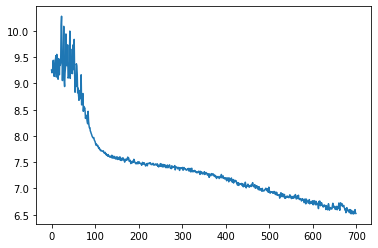

In [34]:
set_seed()

def linear_constraint(backend, model, xvars):
    x=xvars[0]
    return [
        [x<= 0.7 , "center_dist"],
        [x>= 0.3 , "center_dist2"]
    ]

problem = build_problem("polynomial_1D", lambda x: math.sin(x*10)/x/10, ['real'], [[-1,1]])
dataset = problem.get_dataset(20, backend_type='cplex')
problem.y_lb = -1
problem.y_ub = 1

X, Y = [], []
for ii, aa in enumerate(dataset[0]):
    if not (aa > -0.5 and aa < 0.5) :
        X.append(aa)
        Y.append(dataset[1][ii])
X = np.stack(X)
Y = np.stack(Y)

surrogate_cfg = {
    "epochs": 700,
    "learning_rate": 5e-3,
    "weight_decay": 0,
    "batch_size": 1024,
    "depth": 2,
    "width": 40,
}

surrogate_model = EBM(problem, surrogate_cfg, logger)
mdl = surrogate_model.fit_surrogate(X,Y)

Sinc


Start of epoch 0
Training loss  tf.Tensor(9.07931, shape=(), dtype=float32)

Start of epoch 1
Training loss  tf.Tensor(9.169836, shape=(), dtype=float32)

Start of epoch 2
Training loss  tf.Tensor(9.164055, shape=(), dtype=float32)

Start of epoch 3
Training loss  tf.Tensor(8.710825, shape=(), dtype=float32)

Start of epoch 4
Training loss  tf.Tensor(8.753508, shape=(), dtype=float32)

Start of epoch 5
Training loss  tf.Tensor(8.5177965, shape=(), dtype=float32)

Start of epoch 6
Training loss  tf.Tensor(8.414099, shape=(), dtype=float32)

Start of epoch 7
Training loss  tf.Tensor(8.232921, shape=(), dtype=float32)

Start of epoch 8
Training loss  tf.Tensor(8.282977, shape=(), dtype=float32)

Start of epoch 9
Training loss  tf.Tensor(8.074234, shape=(), dtype=float32)

Start of epoch 10
Training loss  tf.Tensor(8.418779, shape=(), dtype=float32)

Start of epoch 11
Training loss  tf.Tensor(8.210039, shape=(), dtype=float32)

Start of epoch 12
Training loss  tf.Tensor(8.000834, shape=()

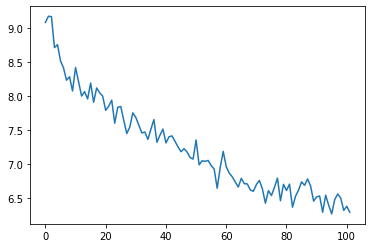

In [6]:
set_seed()

def linear_constraint(backend, model, xvars):
    x=xvars[0]
    return [
        [x<= 0.7 , "center_dist"],
        [x>= 0.3 , "center_dist2"]
    ]

problem = build_problem("polynomial_1D", lambda x: -math.sin(x*10)/x/20, ['real'], [[-1,1]])
dataset = problem.get_dataset(1000, backend_type='cplex')
problem.y_lb = -1
problem.y_ub = 1

X, Y = [], []
for ii, aa in enumerate(dataset[0]):
    X.append(aa)
    Y.append(dataset[1][ii])
X = np.stack(X)
Y = np.stack(Y)

surrogate_cfg = {
    "epochs": 102,
    "learning_rate": 5e-3,
    "weight_decay": 0,
    "batch_size": 64,
    "depth": 2,
    "width": 40,
}

surrogate_model = EBM(problem, surrogate_cfg, logger)
mdl = surrogate_model.fit_surrogate(X,Y)

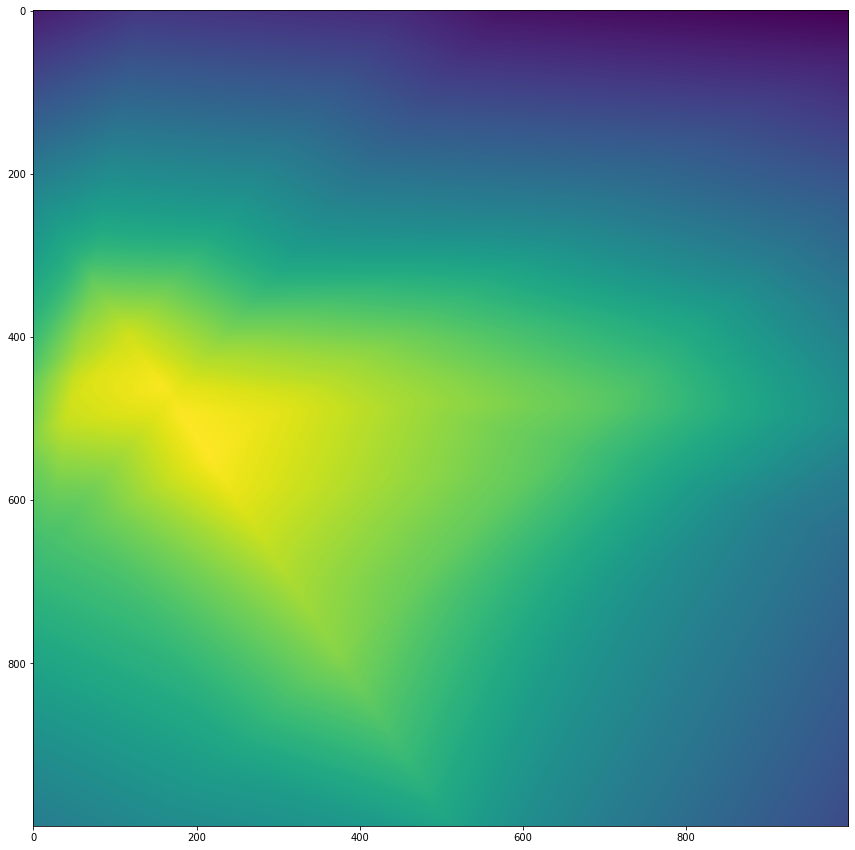

Max prob: 0.049919035
Raw scores min-max: 
 -99.28864 6.7303476


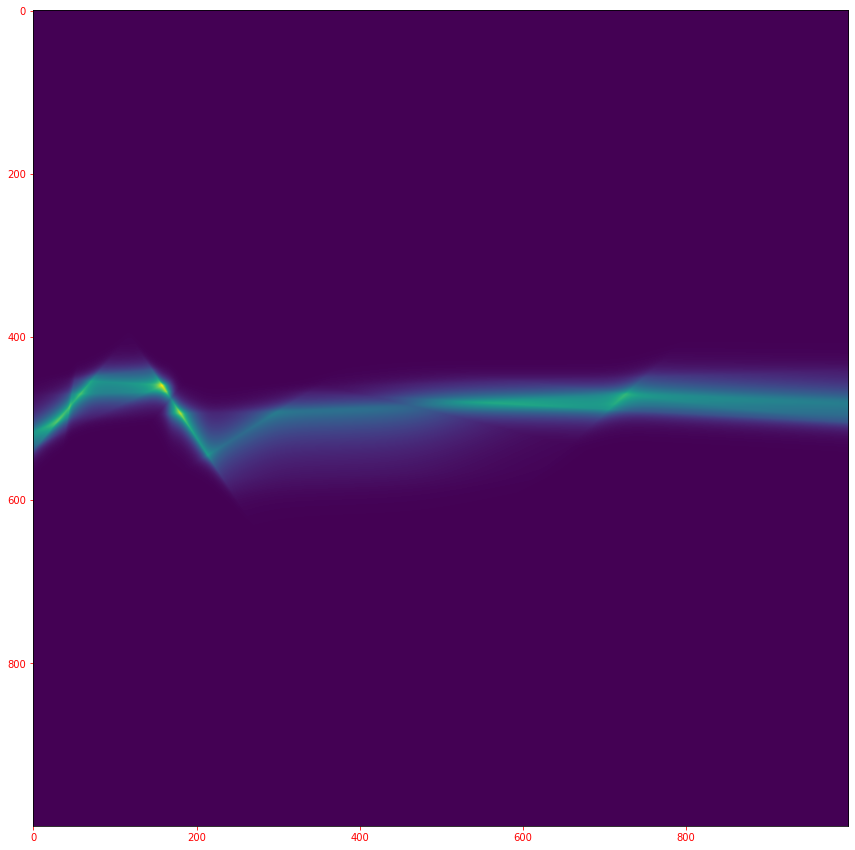

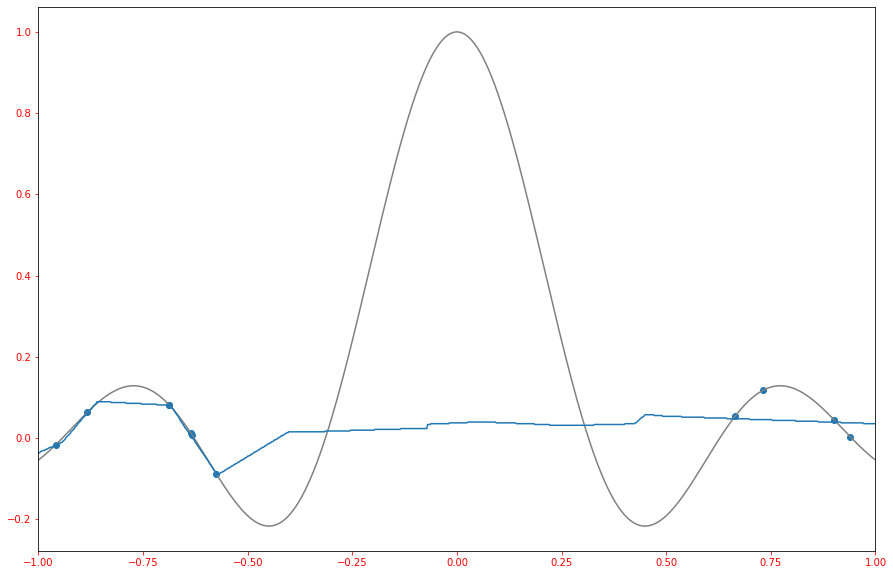

In [35]:
surrogate_model = EBM(problem, surrogate_cfg, logger)
surrogate_model.plot_predictions(mdl, X, Y)

# EML embedding

In [22]:
from emlopt.solvers.base_milp import BaseMILP
from emlopt.emllib.backend import Backend, get_backend
from emlopt.emllib.net.reader.keras_reader import read_keras_sequential
from emlopt.emllib.net.process import fwd_bound_tighthening, ibr_bounds
from emlopt.emllib.net import embed
from emlopt.emllib.util import pwl_exp


class UCB_EBM(BaseMILP):

    def __init__(self, *args, **kwargs):
        super(UCB_EBM, self).__init__(*args, **kwargs)
        self.lambda_ucb = self.cfg['lambda_ucb']

    @timer
    def propagate_bound(self, parsed_model, timeout=30):
        backend = get_backend(self.cfg['backend'])
        bounds = np.array([[0,1]]*(self.problem.input_shape+1)) # input shape + y
        parsed_model.layer(0).update_lb(bounds[:,0])
        parsed_model.layer(0).update_ub(bounds[:,1])
        method = self.cfg.get('bound_propagation', 'both') # both is default
        if method == 'ibr':
            self.logger.debug(f"Using Interval Based Reasoning bound propagation")
            ibr_bounds(parsed_model)
        elif method == 'milp':
            self.logger.debug(f"Using MILP forward bound tighthening bound propagation")
            fwd_bound_tighthening(backend, parsed_model, timelimit=timeout)
        elif method == 'both':
            self.logger.debug(f"Using IBR and then MILP bound propagation")
            ibr_bounds(parsed_model)
            fwd_bound_tighthening(backend, parsed_model, timelimit=timeout)
        else:
            raise Exception('Invalid bound propagation method')
        return parsed_model

    def embed_model(self, bkd, milp_model, parsed_model, new_bounds=None, name=""):
        # bounds computed with propagate bounds method
        score_lb = parsed_model.layer(-1).lb()[0].item()
        score_ub = parsed_model.layer(-1).ub()[0].item()
        self.logger.debug(f"Computed bounds: lb: {score_lb} ub: {score_ub}")
        # x decision variables
        xvars = []
        norm_xvars = []
        bounds = self.problem.input_bounds if new_bounds is None else new_bounds
        for i,b in enumerate(bounds):
            if self.problem.input_type[i] == "int":
                xvars.append(bkd.var_int(milp_model, lb=b[0], ub=b[1], name=f"{name}_x{str(i)}"))
            else:
                xvars.append(bkd.var_cont(milp_model, lb=b[0], ub=b[1], name=f"{name}_x{str(i)}"))
            # NN scaled input
            norm_xvars.append(bkd.var_cont(milp_model, lb=0, ub=1, name=f"{name}_norm_x{str(i)}"))
            bkd.cst_eq(milp_model, norm_xvars[-1] * (b[1] - b[0]), xvars[-1] - b[0], f"{name}_cst_norm_x{str(i)}")
        # y variable
        yvar = bkd.var_cont(milp_model, lb=self.problem.y_lb, ub=self.problem.y_ub, name=f"{name}_y")
        norm_yvar = bkd.var_cont(milp_model, lb=0, ub=1, name=f"{name}_norm_y")
        bkd.cst_eq(milp_model, norm_yvar * (self.problem.y_ub - self.problem.y_lb), yvar - self.problem.y_lb, f"{name}_cst_norm_y")
        # score variable
        scorevar = bkd.var_cont(milp_model, lb=score_lb, ub=score_ub, name=f"{name}_score")
        norm_scorevar = bkd.var_cont(milp_model, lb=0, ub=1, name=f"{name}_norm_score")
        bkd.cst_eq(milp_model, norm_scorevar * (score_ub - score_lb), scorevar - score_lb, f"{name}_cst_norm_score")

        embed.encode(bkd, parsed_model, milp_model, norm_xvars + [norm_yvar], [scorevar], name)
        return xvars, norm_xvars, yvar, norm_yvar, scorevar, norm_scorevar

    def extract_solution(self, solution_vars, name, scaled=False):
        opt_x = np.zeros(self.problem.input_shape)
        for i in range(self.problem.input_shape):
            if scaled:
                opt_x[i] = solution_vars[f"{name}_norm_x"+str(i)]
            else:
                opt_x[i] = solution_vars[f"{name}_x"+str(i)]
        return opt_x

    def solve(self, keras_model, samples_x, samples_y):
        bkd = get_backend(self.cfg['backend'])
        milp_model = bkd.new_model()

        parsed_mdl = read_keras_sequential(keras_model)
        parsed_mdl, _ = self.propagate_bound(parsed_mdl, timeout=30, timer_logger=self.logger)
        xvars, norm_xvars, yvar, norm_yvar, scorevar, norm_scorevar = self.embed_model(bkd, milp_model, parsed_mdl, name='nn1')

        y_delta = bkd.var_cont(milp_model, lb=0, ub=1, name="y_explorer")
        xvars_2, norm_xvars_2, yvar_2, norm_yvar_2, scorevar_2, norm_scorevar_2 = self.embed_model(bkd, milp_model, parsed_mdl, name='nn2')
        for ii,xx in enumerate(xvars):
            bkd.cst_eq(milp_model, xvars[ii], xvars_2[ii], "same_X")
        bkd.cst_eq(milp_model, norm_yvar+y_delta, norm_yvar_2, "y_delta")

        # delta_score = (norm_scorevar-norm_yvar) - (norm_scorevar_2-norm_yvar_2)
        # bin_abs = bkd.var_bin(milp_mode l, name=f"bin_abs_delta_score")
        # abs_delta = bkd.var_cont(milp_model, lb=0, ub=1, name=f"abs delta score")
        # M = 10
        # bkd.add_cst(milp_model, delta_score + M*bin_abs >= abs_delta)
        # bkd.add_cst(milp_model, -delta_score + M*(1-bin_abs) >= abs_delta)
        # bkd.add_cst(milp_model, delta_score <= abs_delta)
        # bkd.add_cst(milp_model, -delta_score <= abs_delta)

        # bkd.add_cst(milp_model, norm_scorevar >= norm_scorevar_2)
        
        # bkd.add_cst(milp_model, norm_scorevar >= 0.6)
        # bkd.add_cst(milp_model, norm_scorevar_2 >= 0.6)

        # bkd.add_cst(milp_model, norm_yvar >= 0.5, "586")
        # bkd.add_cst(milp_model, norm_yvar <= 0.51, "586e")
        # bkd.add_cst(milp_model, norm_xvars[0] >=  0.9, "78678")
        # bkd.add_cst(milp_model, norm_xvars[0] <=  0.901, "7e8678")

        #objective = norm_scorevar - norm_yvar
        objective = norm_scorevar

        if self.problem.constraint_cb is not None:
            csts = self.problem.constraint_cb(bkd, milp_model, xvars)  #TODO: cst xvar2 too
            for pc in csts:
                bkd.add_cst(milp_model, *pc)

        bkd.set_obj(milp_model, 'max', objective)
        bkd.set_determinism(milp_model)
        if self.logger.level == logging.DEBUG:
            bkd.set_extensive_log(milp_model)
        solution = bkd.solve(milp_model, self.solver_timeout)

        if solution['status'] == 'infeasible':
            raise Exception("Not feasible")

        #self.logger.debug(f"Solution: {solution}")
        #decision_variables = self.extract_solution(solution['vars'], "nn1")
        main_variables = {
            "objective": solution['obj'],
            "x": solution['vars']['nn1_x0'],
            "norm_score1": solution['vars']['nn1_norm_score'],
            "norm_score2": solution['vars']['nn2_norm_score'],
            "y1": solution['vars']['nn1_y'],
            "y2": solution['vars']['nn2_y'],
            "norm y delta": solution['vars']['y_explorer'],
        }
        if self.solution_callback is not None:
            self.solution_callback(main_variables, solution)

        #return decision_variables


In [23]:
cfg = {"backend": 'cplex', "lambda_ucb": 1, "solver_timeout": 30}

def cb(main_variables, all_variables):
    logger.debug(main_variables)

milp_model = UCB_EBM(problem, cfg, 1, logger)
milp_model.solution_callback = cb
milp_model.optimize_acquisition_function(mdl, X, Y, timer_logger=logger)

2022-08-19 12:57:19,644 - ebm - DEBUG - Started 'optimize_acquisition_function'
2022-08-19 12:57:19,646 - ebm - DEBUG - UCB_EBM solver:
2022-08-19 12:57:19,671 - ebm - DEBUG - Started 'propagate_bound'
2022-08-19 12:57:19,673 - ebm - DEBUG - Using IBR and then MILP bound propagation
2022-08-19 12:57:26,864 - ebm - DEBUG - Finished 'propagate_bound' in 7.1915 secs
2022-08-19 12:57:26,865 - ebm - DEBUG - Computed bounds: lb: -262.4720142317613 ub: 27.548146217880333
2022-08-19 12:57:27,112 - ebm - DEBUG - Computed bounds: lb: -262.4720142317613 ub: 27.548146217880333
Model: docplex_model15
 - number of variables: 389
   - binary=108, integer=0, continuous=281
 - number of constraints: 386
   - linear=170, indicator=216
 - parameters:
     parameters.parallel = 1
     parameters.randomseed = 42
 - problem type is: MILP
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSe

(None, 8.123751499999344)